In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
display(HTML("<style>.container {width:100% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: roicat


In [2]:
from pathlib import Path
import copy
import functools
import gc

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import natsort
import sklearn
import torch


In [3]:
%load_ext autoreload
%autoreload 2
import bnpm

In [4]:
mouse = 'mouse_0403L'

In [5]:
dir_dFoF = f'/media/rich/bigSSD/analysis_data/face_rhythm/{mouse}/dFoF_aligned/'

if mouse == 'mouse_0322R':
    ## mouse_0322R
    dates_toExclude = [
        '20230507',
        '20230515',
    ]

elif mouse == 'mouse_0403L':
    ## mouse_0403L
    dates_toExclude = [
        '20230719',
    ]

elif mouse == 'mouse_0322N':
    # 0322N
    dates_toExclude = []


else:
    dates_toExclude = []

In [6]:
dir_tca = f'/media/rich/bigSSD/analysis_data/face_rhythm/{mouse}/ws_and_tca__idx_SI/'

In [7]:
paths_dFoF = bnpm.path_helpers.find_paths(
    dir_outer=dir_dFoF,
    reMatch='dFoF_aligned.*npy',
    depth=4,
    natsorted=True,
)

In [8]:
paths_dFoF

['/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/dFoF_aligned/20230703/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/dFoF_aligned/20230705/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/dFoF_aligned/20230706/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/dFoF_aligned/20230707/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/dFoF_aligned/20230708/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/dFoF_aligned/20230709/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/dFoF_aligned/20230710/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/dFoF_aligned/20230711/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/dFoF_aligned/20230712/dFoF_aligned .npy',
 '/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/dFoF_aligned/20230713/dFoF_align

In [9]:
dates_dFoF = [Path(p).parts[-2] for p in paths_dFoF]

In [10]:
# display(dates)
# display(paths_dFoF)

In [11]:
dFoFs = {d: np.load(p, mmap_mode='r') for d, p in zip(dates_dFoF, paths_dFoF)}

In [12]:
for date in dates_toExclude:
    try:
        dFoFs.pop(date)
    except:
        print(f'failed to exclude date: {date}')

In [13]:
paths_tca = bnpm.path_helpers.find_paths(
    dir_outer=dir_tca,
    reMatch='tca.*npy',
    depth=4,
    natsorted=True,
    verbose=True,
)

dates_tca = [Path(p).parts[-2] for p in paths_tca]

Found file: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/ws_and_tca__idx_SI/20230703/tca_idxSI.npy
Found file: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/ws_and_tca__idx_SI/20230705/tca_idxSI.npy
Found file: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/ws_and_tca__idx_SI/20230706/tca_idxSI.npy
Found file: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/ws_and_tca__idx_SI/20230707/tca_idxSI.npy
Found file: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/ws_and_tca__idx_SI/20230708/tca_idxSI.npy
Found file: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/ws_and_tca__idx_SI/20230709/tca_idxSI.npy
Found file: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/ws_and_tca__idx_SI/20230710/tca_idxSI.npy
Found file: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/ws_and_tca__idx_SI/20230711/tca_idxSI.npy
Found file: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/ws_and_tca__idx_SI/20230712/tca_idxSI.npy
F

In [14]:
tcas = {d: np.load(p, mmap_mode='r') for d, p in zip(dates_tca, paths_tca)}

In [15]:
def prep_array_for_regression(arr, mean_sub=False, std_div=False, device='cpu', nan_to_zero=True):
    out = torch.as_tensor(arr, dtype=torch.float32, device=device)
    if mean_sub:
        out = out - torch.nanmean(out, dim=0, keepdim=True)
    out = torch.nan_to_num(out, nan=0.0) if nan_to_zero else out
    if std_div:
        out = out / out.std(0, keepdim=True)
    return out

In [16]:
DEVICE_regression = bnpm.torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


In [17]:
dFoFs_prep = {date: prep_array_for_regression(d.T, mean_sub=True, std_div=False, device='cpu', nan_to_zero=False) for date, d in tqdm(dFoFs.items())}

  0%|                                                    | 0/35 [00:00<?, ?it/s]/tmp/ipykernel_2238560/297969921.py:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  out = torch.as_tensor(arr, dtype=torch.float32, device=device)
100%|███████████████████████████████████████████| 35/35 [00:12<00:00,  2.85it/s]


In [18]:
tcas_prep = {date: prep_array_for_regression(t, mean_sub=True, std_div=True, device='cpu', nan_to_zero=False) for date, t in tqdm(tcas.items())}

100%|██████████████████████████████████████████| 38/38 [00:00<00:00, 156.00it/s]


In [19]:
automodel_partial = functools.partial(
    bnpm.automatic_regression.Auto_RidgeRegression,
    params_RidgeRegression={
        # 'alpha': [1e0, 1e7],
        'alpha': 10**3.5,
        'fit_intercept': False,
#         'max_iter': 1000,
#         'tol': 0.0001,
#         'solver': 'cholesky',
#         'positive': False,
    },
    n_startup=36*1,
    kwargs_convergence={
        'n_patience': 36*1,
        'tol_frac': 0.01,
        # 'max_trials': 100,
        'max_trials': 1,
        'max_duration': 60*10,
    }, 
    # n_repeats=300,
    n_repeats=1,
    fn_reduce_repeats=torch.median,
    # n_jobs_optuna=2,
    n_jobs_optuna=1,
    penalty_testTrainRatio=1e0,
    test_size=0.3,
    verbose=False,
    use_rich_method=True,
)

In [20]:
dates_matched = [date for date in tcas.keys() if date in dFoFs.keys()]

In [21]:
# Intra-session models and EVRs
n_splits = 1
test_size = 0.3

alpha = 10**3.5

models = {}
evrs = {}
evrs_total = {}
alphas = {}
for date in tqdm(dates_matched[:]):
    dfof = dFoFs_prep[date].to(DEVICE_regression)
    tca = tcas_prep[date].to(DEVICE_regression)
    
    cv = sklearn.model_selection.GroupShuffleSplit(n_splits=1, test_size=test_size)
    cv.split = functools.partial(cv.split, groups=bnpm.cross_validation.make_groups(n_samples=dfof.shape[0], group_size=30*60*2))
    idx_samples = np.arange(dfof.shape[0])
    splits = [next(cv.split(idx_samples)) for ii in range(n_splits)]

    X = tca
    n_X = X.shape[1]

    # remove NaNs from dFoF
    Y = dfof
    n_Y_original = Y.shape[1]
    idx_noNan = torch.where(torch.isnan(Y).sum(0) == 0)[0]
    Y = Y[:, idx_noNan]
    n_Y = Y.shape[1]
    
    automodel = automodel_partial(X=X, y=Y, cv=cv)
    automodel.fit()
    model = copy.deepcopy(automodel.model_best)
    
    # put NaNs back into coef_
    tmp = torch.ones((n_X, n_Y_original), dtype=model.coef_.dtype, device=model.coef_.device) * torch.nan
    tmp[:, idx_noNan] = model.coef_
    model.coef_ = tmp
    # put NaNs back into intercept_
    tmp = torch.ones((n_Y_original, ), dtype=model.intercept_.dtype, device=model.intercept_.device) * torch.nan
    tmp[idx_noNan] = model.intercept_
    model.intercept_ = tmp
    
    # save the model into a dict
    models[date] = copy.deepcopy(model)
    alphas[date] = model.alpha


    # test model to get intra-session EVRs
    idx_Y_noNan = torch.where(torch.isnan(Y).sum(0) == 0)[0]
    evrs[date] = np.full(shape=(n_Y, n_splits), fill_value=np.nan, dtype=np.float32)
    evrs_total[date] = np.full(shape=(n_splits, ), fill_value=np.nan, dtype=np.float32)
    for i_split in range(n_splits):
        idx_train, idx_test = splits[i_split]
        X_train, Y_train, X_test, Y_test = X[idx_train, :], Y[idx_train, :], X[idx_test, :], Y[idx_test, :]
        model = bnpm.linear_regression.Ridge(
            # alpha=alphas[date][i_y], 
            alpha=alpha,
            fit_intercept=False, 
            X_precompute=X_train,
        )
        
        model.fit(
            X=X_train, 
            y=Y_train,
        )
        Y_rec = model.predict(X=X_test)
        v1_orth, EVR, EVR_total, _ = bnpm.similarity.orthogonalize(
            v1=Y_test,
            v2=Y_rec,
            method='OLS',
            device=DEVICE_regression,
        )

        evrs[date][:, i_split] = EVR.cpu().numpy()
        evrs_total[date][i_split] = EVR_total.cpu().numpy()

100%|███████████████████████████████████████████| 35/35 [00:33<00:00,  1.05it/s]


In [22]:
def dict_to_numpy(d):
    out = {}
    for key, val in d.items():
        if isinstance(val, dict):
            out[key] = dict_to_numpy(val)
        elif isinstance(val, torch.Tensor):
            out[key] = val.cpu().numpy()
        elif isinstance(val, np.ndarray):
            out[key] = val
        else:
            out[key] = val

    return out

In [23]:
def reduce_dimensionality(array, r):
    """
    Reduce the dimensionality of an array using PCA.

    Parameters:
    array (numpy.ndarray): Input array of shape (n_samples, n_features).
    r (int): Desired rank.

    Returns:
    numpy.ndarray: Array with reduced dimensions of shape (n_samples, r).
    """
    from sklearn.decomposition import PCA
    pca = PCA(n_components=r)
    reduced_array = pca.fit_transform(array)
    recreated_array = pca.inverse_transform(reduced_array)
    return recreated_array

In [24]:
# Cross-session models and EVRs
DEVICE_regression = bnpm.torch_helpers.set_device(use_GPU=True)

crossmodel_outs = np.zeros((len(dates_matched), len(dates_matched)), dtype=object)
for ii, date_i in tqdm(enumerate(dates_matched), total=len(dates_matched)):
    dfof_i = dFoFs_prep[date_i].to(DEVICE_regression)
    tca_i  = tcas_prep[date_i].to(DEVICE_regression)

    # Prepare model for session i
    model = bnpm.linear_regression.Ridge(
        # alpha=alphas[date][i_y], 
        alpha=alpha,
        fit_intercept=False, 
        X_precompute=tca_i,
    )
    
    # Iterate over each cross-session j
    for jj, date_j in enumerate(dates_matched):
        dfof_j = dFoFs_prep[date_j].to(DEVICE_regression)
        tca_j  = tcas_prep[date_j].to(DEVICE_regression)
        
        # Find neurons present in both i and j sessions ('_intersect')
        idx_noNan_i = torch.isnan(dfof_i).sum(0) == 0
        idx_noNan_j = torch.isnan(dfof_j).sum(0) == 0
        idx_noNan_intersect = torch.as_tensor(idx_noNan_i * idx_noNan_j, device=dfof_i.device, dtype=torch.bool)
                
        # Fit the model_i. Must be done for each j because the intersecting neurons will be different for each ij pair
        model.fit(
            X=tca_i, 
            y=dfof_i[:, idx_noNan_intersect],
        )
        
        # Calculate EVR_ij
        Y_rec_ij = model.predict(X=tca_j)
        v1_orth, EVR_ij, EVR_total_weighted_ij, EVR_total_unweighted_ij = bnpm.similarity.pairwise_orthogonalization_torch(
            v1=dfof_j[:, idx_noNan_intersect],
            v2=Y_rec_ij,
            center=True,
            device=DEVICE_regression,
        )

        # Calculate EVR_ii for normalization
        Y_rec_ii = model.predict(X=tca_i)
        v1_orth, EVR_ii, EVR_total_weighted_ii, EVR_total_unweighted_ii = bnpm.similarity.pairwise_orthogonalization_torch(
            v1=dfof_i[:, idx_noNan_intersect],
            v2=Y_rec_ii,
            center=True,
            device=DEVICE_regression,
        )
    
        # Store results
        model_numpy = model.numpy()
        crossmodel_outs[ii, jj] = {}
        crossmodel_outs[ii, jj]['thetas'] = model_numpy.coef_.copy()
        crossmodel_outs[ii, jj]['biases'] = model_numpy.intercept_.copy()
        crossmodel_outs[ii, jj]['orthogonalization'] = {
            'EVR_ij': EVR_ij.cpu().numpy(), 
            'EVR_ii': EVR_ii.cpu().numpy(), 
            'EVR_total_weighted_ij': EVR_total_weighted_ij.cpu().numpy(), 
            'EVR_total_weighted_ii': EVR_total_weighted_ii.cpu().numpy(),
        }
        crossmodel_outs[ii, jj] = dict_to_numpy(crossmodel_outs[ii, jj])

[m.numpy() for m in models.values()];

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


100%|███████████████████████████████████████████| 35/35 [04:47<00:00,  8.22s/it]


In [25]:
bnpm.torch_helpers.clear_cuda_cache()

In [53]:
# EVRs = np.zeros(tuple(crossmodel_outs.shape) + (rank,), dtype=np.float32)
EVRs_ij = np.zeros(tuple(crossmodel_outs.shape), dtype=np.float32)
EVRs_ii = np.zeros(tuple(crossmodel_outs.shape), dtype=np.float32)

for ii in range(EVRs.shape[0]):
    for jj in range(EVRs.shape[1]):
        EVRs_ij[ii,jj] = crossmodel_outs[ii,jj]['orthogonalization']['EVR_total_weighted_ij']
        EVRs_ii[ii,jj] = crossmodel_outs[ii,jj]['orthogonalization']['EVR_total_weighted_ii']
        # test2[ii,jj] = crossmodel_outs[ii,jj]['orthogonalization']['EVR'][3]

In [54]:
EVRs_ij = EVRs_ij[:,:,None]
EVRs_ii = EVRs_ii.T[:,:,None]

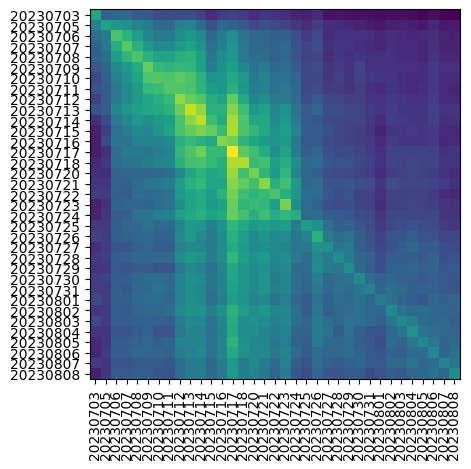

In [55]:
plt.figure()
plt.imshow(EVRs_ij)
plt.xticks(np.arange(EVRs_ij.shape[0]), labels=models.keys(), rotation=90);
plt.yticks(np.arange(EVRs_ij.shape[0]), labels=models.keys(), rotation=0);


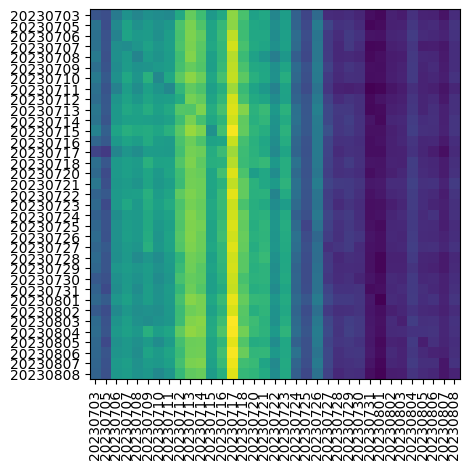

In [56]:
plt.figure()
plt.imshow(EVRs_ii)
plt.xticks(np.arange(EVRs_ij.shape[0]), labels=models.keys(), rotation=90);
plt.yticks(np.arange(EVRs_ij.shape[0]), labels=models.keys(), rotation=0);


In [59]:
%matplotlib notebook

<IPython.core.display.Javascript object>


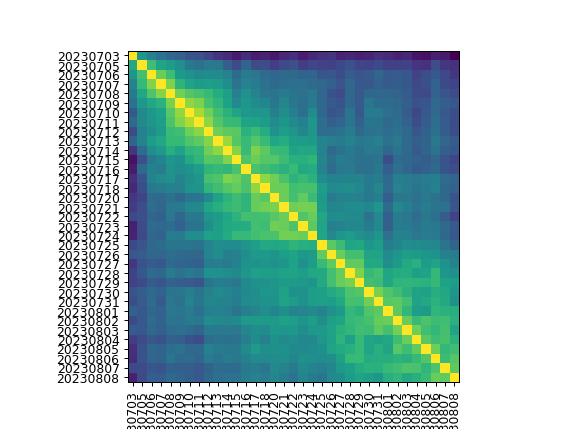

In [60]:
plt.figure()
plt.imshow(EVRs_ij / EVRs_ii)
plt.xticks(np.arange(EVRs_ij.shape[0]), labels=models.keys(), rotation=90);
plt.yticks(np.arange(EVRs_ij.shape[0]), labels=models.keys(), rotation=0);


In [58]:
make_symmetric = lambda x: (x + x.transpose(1,0,2))/2

EVRs_symm = make_symmetric(EVRs)

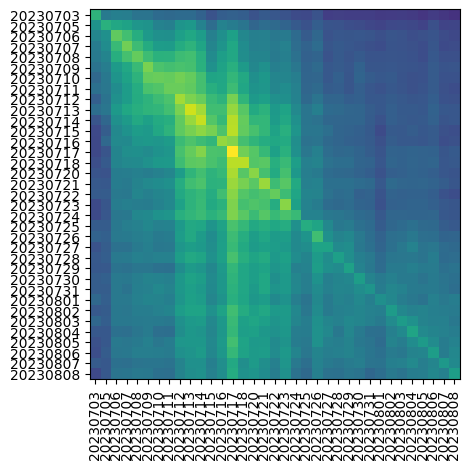

In [30]:
fig = plt.figure()
plt.imshow(EVRs.mean(2), clim=[0,None])
plt.xticks(np.arange(EVRs.shape[0]), labels=models.keys(), rotation=90);
plt.yticks(np.arange(EVRs.shape[0]), labels=models.keys(), rotation=0);
# figsaver(fig, name_file='EVRs_raw')


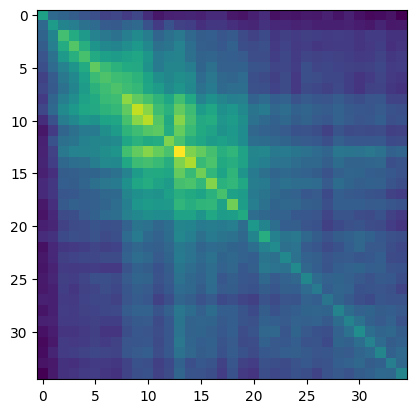

In [31]:
plt.figure()
plt.imshow(EVRs_symm.mean(2))

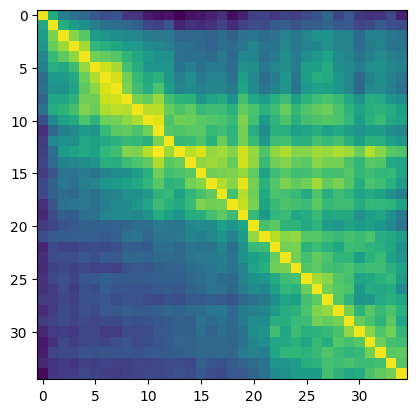

In [32]:
plt.figure()
plt.imshow(EVRs_symm.mean(2) / EVRs_symm.mean(2).diagonal(offset=0)[None,:])

In [33]:
EVRs_norm = EVRs_symm / EVRs_symm.diagonal(offset=0).T[:,None]

In [34]:
EVRs_norm = EVRs / EVRs.diagonal(offset=0).T[:, None]

In [35]:
EVRs_norm[range(EVRs_norm.shape[0]), range(EVRs_norm.shape[0]), :] = 0

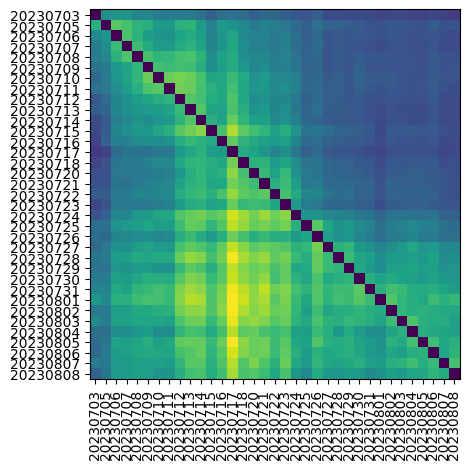

In [40]:
%matplotlib inline
fig = plt.figure()
plt.imshow(
    EVRs_norm.mean(2),
#     clim=[0,1],
)
plt.xticks(np.arange(EVRs_norm.shape[0]), labels=models.keys(), rotation=90);
plt.yticks(np.arange(EVRs_norm.shape[0]), labels=models.keys(), rotation=0);
# figsaver(fig, name_file='EVRs_norm')

In [37]:
comps, scores, singVals, EVR = bnpm.decomposition.torch_pca(X_in=Y)

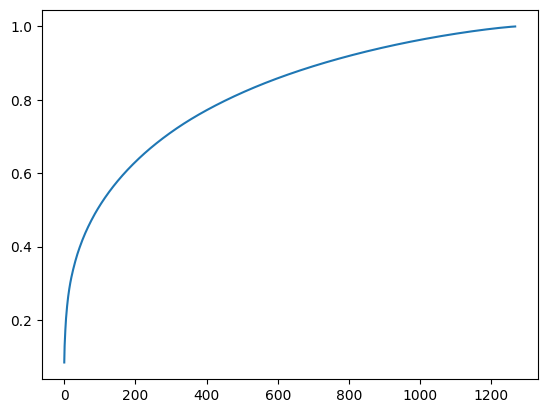

In [38]:
plt.figure()
plt.plot(np.cumsum(EVR))

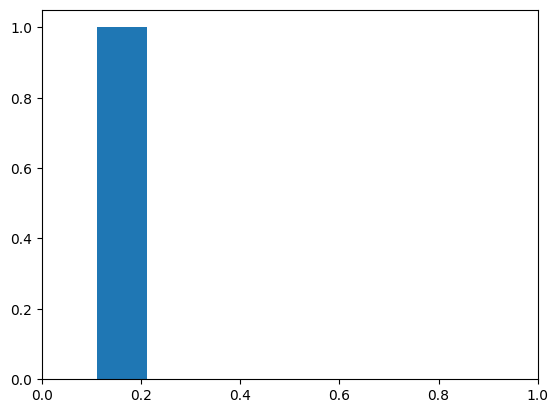

In [39]:
plt.figure()
plt.hist(evrs_total['20230706'])
plt.xlim([0, 1.0]);

In [378]:
DEVICE_regression = bnpm.torch_helpers.set_device(use_GPU=True)

n_splits = 30
test_size = 0.3

alpha = 10**3.5

models = {}
evrs = {}
alphas = {}
for date in tqdm(list(tcas.keys())[:]):
    if date not in dFoFs:
        continue
    dfof = dFoFs[date].T.copy()
    dfof = prep_array_for_regression(dfof, mean_sub=True, std_div=True)
    
    tca = tcas[date].copy()
    tca = prep_array_for_regression(tca, mean_sub=True, std_div=True)
    
    cv = sklearn.model_selection.GroupShuffleSplit(n_splits=1, test_size=test_size)
    cv.split = functools.partial(cv.split, groups=bnpm.cross_validation.make_groups(n_samples=dfof.shape[0], group_size=30*60*2))
    idx_samples = np.arange(dfof.shape[0])
    splits = [next(cv.split(idx_samples)) for ii in range(n_splits)]

    X = tca
    n_X = X.shape[1]

    Y = dfof
    n_Y = Y.shape[1]
    
    # models[date] = np.empty(shape=(n_Y, ), dtype=object)
    # alphas[date] = np.full(shape=(n_Y, ), fill_value=np.nan, dtype=np.float32)
    # for i_y in tqdm(range(n_Y), disable=False):    
    #     y = Y[:, i_y][:, None]
    #     if torch.isnan(y.sum()) > 0:
    #         continue
    #     automodel = automodel_partial(X=X, y=y, cv=cv)
    #     automodel.fit()
    #     model = copy.deepcopy(automodel.model_best)
    #     models[date][i_y] = copy.deepcopy(model)
    #     alphas[date][i_y] = model.alpha

    
    idx_Y_noNan = torch.where(torch.isnan(Y).sum(0) == 0)[0]
    evrs[date] = np.full(shape=(n_Y, n_splits), fill_value=np.nan, dtype=np.float32)
    for i_split in tqdm(range(n_splits)):
        idx_train, idx_test = splits[i_split]
        X_train, Y_train, X_test, Y_test = X[idx_train, :], Y[idx_train, :], X[idx_test, :], Y[idx_test, :]
        model = bnpm.linear_regression.Ridge(
            # alpha=alphas[date][i_y], 
            alpha=alpha,
            fit_intercept=False, 
            X_precompute=X_train,
        )
        
        for i_y in idx_Y_noNan:
            y_train, y_test = Y_train[:, i_y], Y_test[:, i_y]
            model.fit(
                X=X_train, 
                y=y_train,
            )
            y_rec = model.predict(X=X_test)
            v1_orth, EVR, _, _ = bnpm.similarity.orthogonalize(
                v1=y_test,
                v2=y_rec,
                method='OLS',
                device=DEVICE_regression,
            )

            evrs[date][i_y, i_split] = EVR[0].cpu().numpy()

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


100%|███████████████████████████████████████████| 38/38 [21:17<00:00, 33.61s/it]


In [601]:
bnpm.file_helpers.pickle_save(
    obj=evrs,
    filepath=f'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/encoding_drift_singleCell.pkl',
)

In [380]:
evrs['20230705'].shape

(1391, 30)

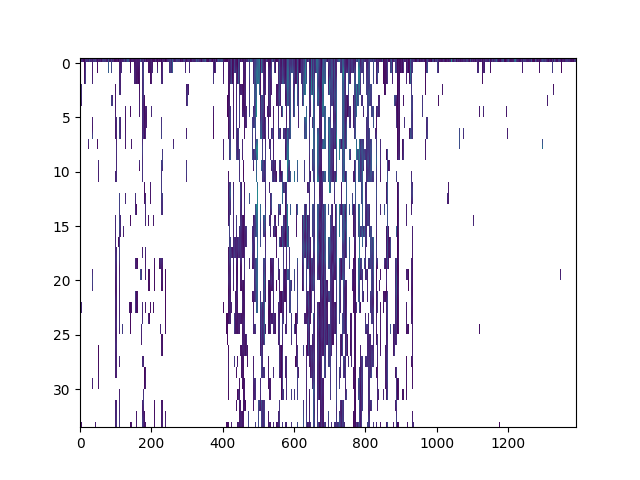

In [381]:
plt.figure()
plt.imshow(np.stack([e.mean(1) for e in evrs.values()], axis=0), aspect='auto')

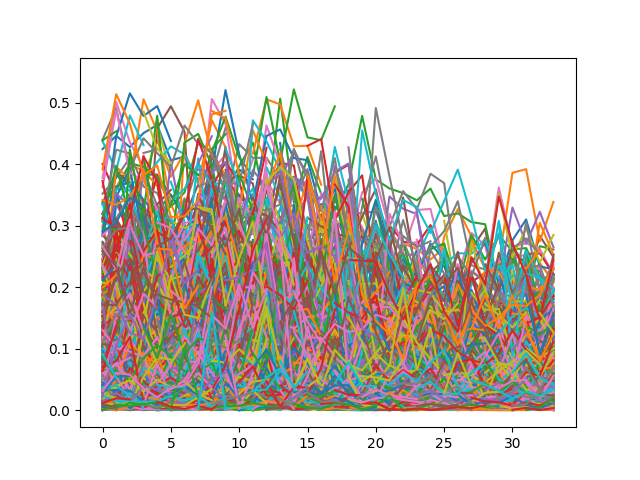

In [382]:
plt.figure()
plt.plot(np.stack([e.mean(1) for e in evrs.values()], axis=0));

In [385]:
evrs_array = np.stack(list(evrs.values()), axis=0)

In [386]:
evrs_array.shape

(34, 1391, 30)

In [404]:
evrs_array_mean = np.nanmean(evrs_array, axis=2)

/tmp/ipykernel_254110/3061912958.py:1: RuntimeWarning: Mean of empty slice
  evrs_array_mean = np.nanmean(evrs_array, axis=2)


In [406]:
evrs_array_mean.shape

(34, 1391)

In [493]:
def geometric_mean(a, axis=None):
    if isinstance(a, torch.Tensor):
        exp, log = torch.exp, torch.log
        mean = functools.partial(torch.mean, dim=axis)
    elif isinstance(a, np.ndarray):
        exp, log = np.exp, np.log
        mean = functools.partial(np.mean, axis=axis)
    return exp(mean(log(a)))

In [594]:
def xcorr_geometricMean_of_ratios(a, b, max_lag=10):
    if isinstance(a, torch.Tensor):
        arange = functools.partial(torch.arange, dtype=torch.int64)
        stack = functools.partial(torch.stack, dim=0)
    elif isinstance(a, np.ndarray):
        arange = functools.partial(np.arange, dtype=np.int64)
        stack = functools.partial(np.stack, axis=0)

    gmean = functools.partial(geometric_mean, axis=0)
    
    left = [gmean(a[:-ii] / b[ii:]) for ii in range(1, max_lag + 1)]
    left.reverse()
    mid = gmean(a / b)
    right = [gmean(a[ii:] / b[:-ii]) for ii in range(1, max_lag + 1)]
    
    xaxis = arange(-max_lag, max_lag+1)
    return stack(left + [mid] + right), xaxis

In [579]:
evrs_array_mean.shape

(34, 1391)

In [595]:
test = evrs_array_mean.copy()

test[test < 0.03] = np.nan

out, xaxis = xcorr_geometricMean_of_ratios(test, test, max_lag=30)

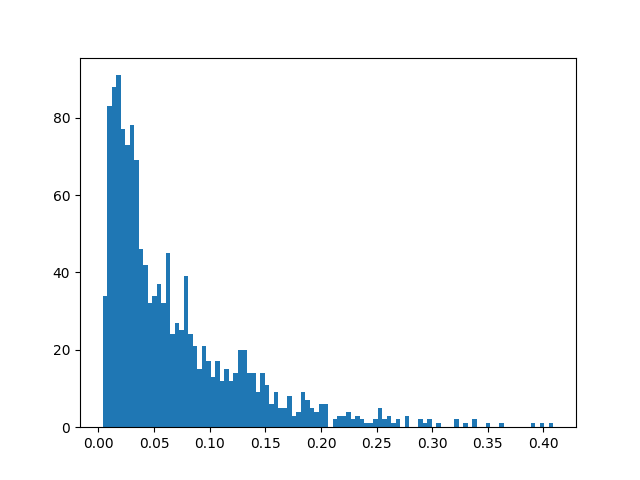

In [596]:
plt.figure()
plt.hist(np.nanmean(evrs_array_mean, axis=0), 100);

(0.5, 1.5)

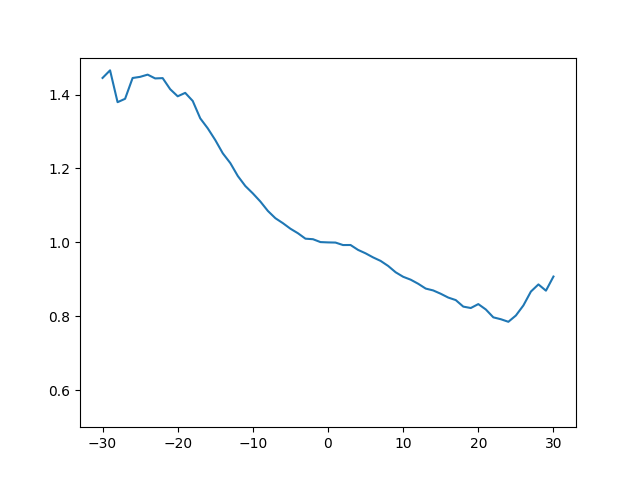

In [597]:
plt.figure()
plt.plot(xaxis, np.nanmean(out, axis=1));
plt.ylim([0.5, 1.5])

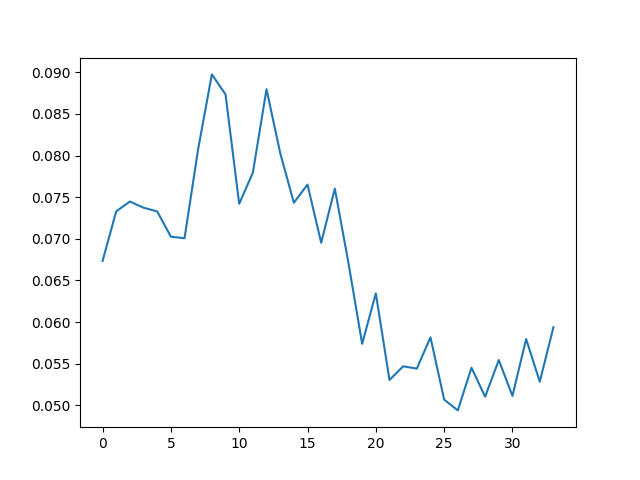

In [592]:
plt.figure()
plt.plot(np.nanmean(evrs_array_mean, axis=1))

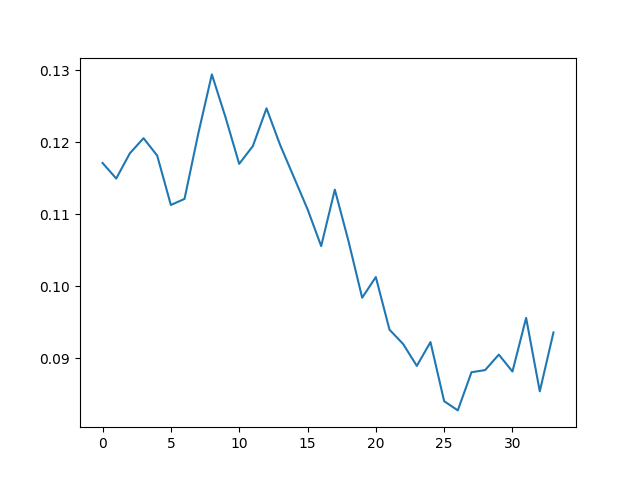

In [593]:
plt.figure()
plt.plot(np.nanmean(test, axis=1))

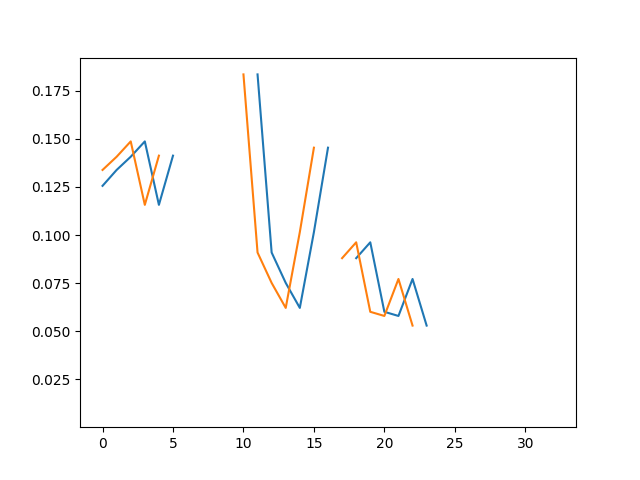

In [430]:
plt.figure()
# plt.plot(test)
plt.plot(test[:-1])
plt.plot(test[1:])

In [394]:
np.nanmean(evrs_array, axis=2).mean(0)

/tmp/ipykernel_254110/3714504024.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(evrs_array, axis=2).mean(0)


array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [401]:
np.argsort(np.nanmean(evrs_array, axis=2).mean(0))

/tmp/ipykernel_254110/3658015605.py:1: RuntimeWarning: Mean of empty slice
  np.argsort(np.nanmean(evrs_array, axis=2).mean(0))


array([  88,  889,  832, ...,  458,  456, 1390])

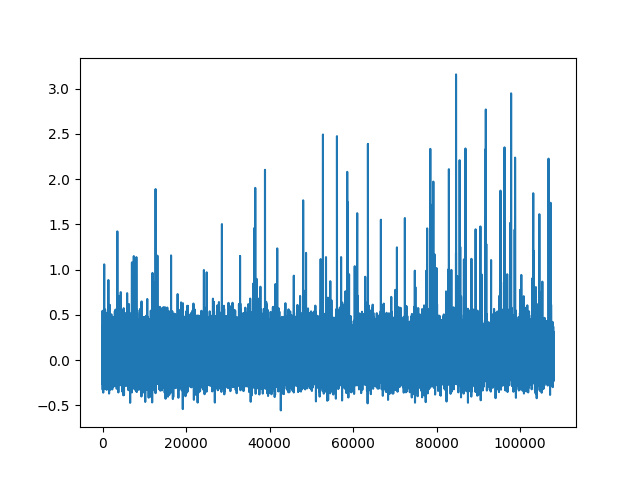

In [403]:
plt.figure()
plt.plot(dFoFs['20230705'][88])

/tmp/ipykernel_254110/340875386.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


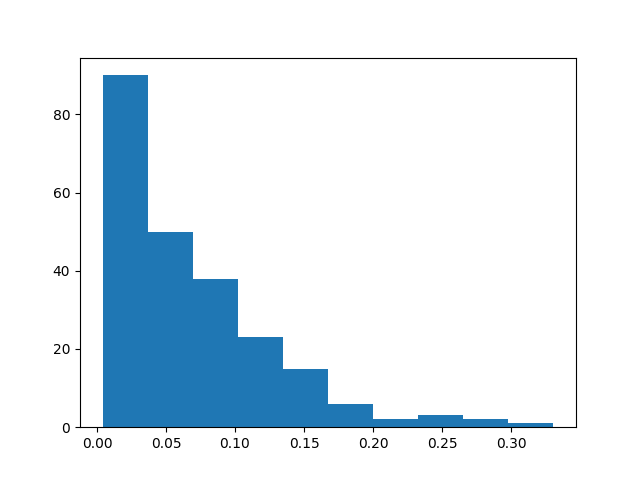

In [389]:
plt.figure()
plt.hist(evrs_array.mean(2).mean(0));

In [18]:
DEVICE_regression = bnpm.torch_helpers.set_device(use_GPU=True)

n_splits = 1
test_size = 0.3

# automodels = {}
models = {}
alphas = {}
evrs_date = {}
for date in tqdm(tcas.keys()):
    if date not in dFoFs:
        continue
        
    dfof = prep_array_for_regression(dFoFs[date].T, mean_sub=True, std_div=False, device=DEVICE_regression)
    tca  = prep_array_for_regression(tcas[date], mean_sub=True, std_div=True, device=DEVICE_regression)

    cv = sklearn.model_selection.GroupShuffleSplit(n_splits=1, test_size=test_size)
    cv.split = functools.partial(cv.split, groups=bnpm.cross_validation.make_groups(n_samples=dfof.shape[0], group_size=30*60*2))
    
    alphas[date] = []
#     automodels[date] = []
    models[date] = []
    for i_tca, t in enumerate(tca.T):
        automodel = automodel_partial(
            X=dfof,
            y=t[:,None],
            cv=cv,
        )
        automodel.fit()
#         automodel.plot_param_curve('alpha')
        
#         automodels[date].append(copy.deepcopy(automodel.numpy()))
        models[date].append(automodel.model_best.numpy())
    
        alphas[date].append(automodel.model_best.alpha)
        
    evrs_tca = []
    for i_tca, t in enumerate(tca.T):
        model = bnpm.linear_regression.Ridge(alpha=alphas[date][i_tca], fit_intercept=False)
        evrs_splits = []
        for i_split in range(n_splits):
            idx_train, idx_test = next(cv.split(np.arange(dfof.shape[0])))
            model.fit(
                X=dfof[idx_train, :], 
                y=t[idx_train, None],
            )
            y_rec = model.predict(X=dfof[idx_test, :])
            v1_orth, EVR, _, _ = bnpm.similarity.orthogonalize(
                v1=t[idx_test, None],
                v2=y_rec,
                method='OLS',
                device=DEVICE_regression,
            )
#             evr_tmp = model.score(
#                 X=dfof[idx_test, :],
#                 y=t[idx_test, None],
#             )
            evrs_splits.append(EVR[0].cpu().numpy())
        evrs_tca.append(np.stack(evrs_splits))
    evrs_date[date] = np.stack(evrs_tca, axis=0)
    

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


  0%|                                                    | 0/31 [00:00<?, ?it/s]/tmp/ipykernel_254110/3601457104.py:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  out = torch.as_tensor(arr, dtype=torch.float32, device=device)
100%|███████████████████████████████████████████| 31/31 [00:18<00:00,  1.66it/s]


cross-model

In [19]:
def dict_to_numpy(d):
    out = {}
    for key, val in d.items():
        if isinstance(val, dict):
            out[key] = dict_to_numpy(val)
        elif isinstance(val, torch.Tensor):
            out[key] = val.cpu().numpy()
        elif isinstance(val, np.ndarray):
            out[key] = val
        else:
            out[key] = val

    return out

In [20]:
crossmodel_outs = np.zeros((len(models), len(models)), dtype=object)
for ii, date_i in tqdm(enumerate(list(models.keys()))):
    dfof_i = prep_array_for_regression(dFoFs[date_i], mean_sub=True, std_div=False, device=DEVICE_regression)
    tca_i  = prep_array_for_regression(tcas[date_i], mean_sub=True, std_div=True, device=DEVICE_regression)
    
    for jj, date_j in enumerate(models.keys()):
        thetas = np.concatenate([m.numpy().coef_ for m in models[date_j]], axis=1)
        biases = np.concatenate([m.numpy().intercept_ for m in models[date_j]])
        y_rec = np.concatenate([m.to(DEVICE_regression).predict(X=dfof_i.T).cpu().numpy() for m in models[date_j]], axis=1)
    
        v1_orth, EVR, EVR_total_weighted, EVR_total_unweighted = bnpm.similarity.pairwise_orthogonalization_torch(
            v1=tca_i,
            v2=y_rec,
            center=True,
            device=DEVICE_regression,
        )
    
        crossmodel_outs[ii, jj] = {}
        crossmodel_outs[ii, jj]['thetas'] = thetas
#         crossmodel_outs[ii, jj]['y_recs'] = y_rec
        crossmodel_outs[ii, jj]['biases'] = biases
        crossmodel_outs[ii, jj]['orthogonalization'] = {
#             'v1_orth': v1_orth, 
            'EVR': EVR, 
            'EVR_total_weighted': EVR_total_weighted, 
            'EVR_total_unweighted': EVR_total_unweighted, 
        }
        crossmodel_outs[ii, jj] = dict_to_numpy(crossmodel_outs[ii, jj])

[[m.numpy() for m in ms] for ms in models.values()];

30it [00:10,  2.86it/s]


In [21]:
rank = crossmodel_outs[0,0]['thetas'].shape[1]

In [22]:
EVRs = np.zeros(tuple(crossmodel_outs.shape) + (rank,), dtype=np.float32)
for ii in range(EVRs.shape[0]):
    for jj in range(EVRs.shape[1]):
        EVRs[ii,jj] = crossmodel_outs[ii,jj]['orthogonalization']['EVR']
        # test2[ii,jj] = crossmodel_outs[ii,jj]['orthogonalization']['EVR'][3]

In [23]:
EVRs[range(EVRs.shape[0]), range(EVRs.shape[1]), :] = np.array([e.mean(1) for e in evrs_date.values()])

In [24]:
make_symmetric = lambda x: (x + x.transpose(1,0,2))/2

EVRs_symm = make_symmetric(EVRs)

In [25]:
%matplotlib inline
figsaver = bnpm.plotting_helpers.Figure_Saver(
    dir_save=f'/media/rich/bigSSD/analysis_data/face_rhythm/{mouse}/drift/ims',
    format_save=['png'],
    overwrite=True,
)

RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/EVRs_raw.png already exists.


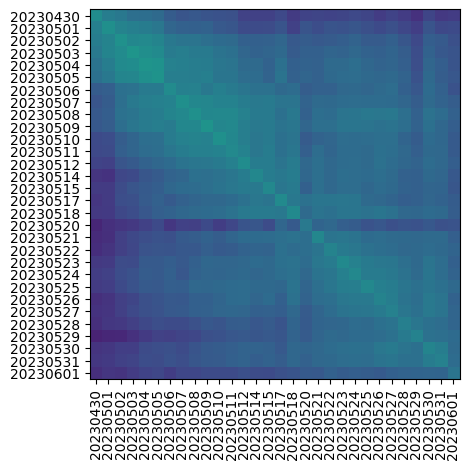

In [26]:
fig = plt.figure()
plt.imshow(EVRs.mean(2), clim=[0,1])
plt.xticks(np.arange(EVRs.shape[0]), labels=models.keys(), rotation=90);
plt.yticks(np.arange(EVRs.shape[0]), labels=models.keys(), rotation=0);
figsaver(fig, name_file='EVRs_raw')


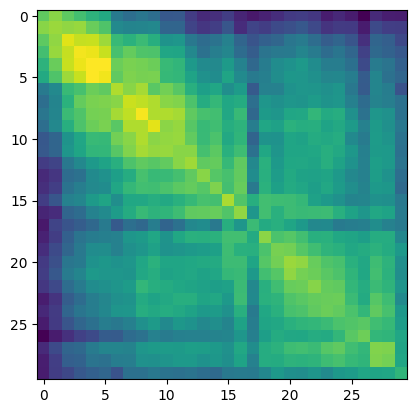

In [70]:
plt.figure()
plt.imshow(EVRs_symm.mean(2))

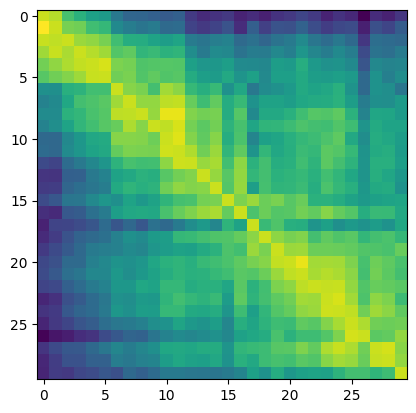

In [71]:
plt.figure()
plt.imshow(EVRs_symm.mean(2) / EVRs_symm.mean(2).diagonal(offset=0)[None,:])

In [72]:
EVRs_norm = EVRs_symm / EVRs_symm.diagonal(offset=0).T[:,None]

In [73]:
EVRs_norm[range(EVRs_norm.shape[0]), range(EVRs_norm.shape[0]), :] = 0

RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/EVRs_norm.png already exists.


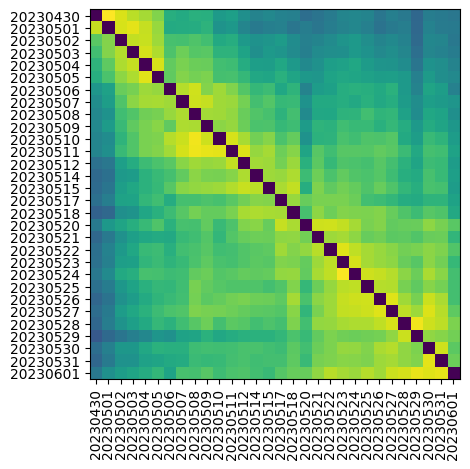

In [74]:
%matplotlib inline
fig = plt.figure()
plt.imshow(EVRs_norm.mean(2))
plt.xticks(np.arange(EVRs_norm.shape[0]), labels=models.keys(), rotation=90);
plt.yticks(np.arange(EVRs_norm.shape[0]), labels=models.keys(), rotation=0);
figsaver(fig, name_file='EVRs_norm')

RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_0.png already exists.
RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_1.png already exists.
RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_2.png already exists.
RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_3.png already exists.
RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_4.png already exists.
RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_5.png already exists.
RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/factors/factor_6.png already exists.
RH Warning: Overwrit

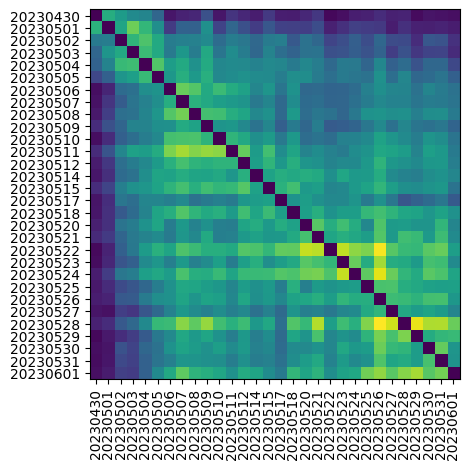

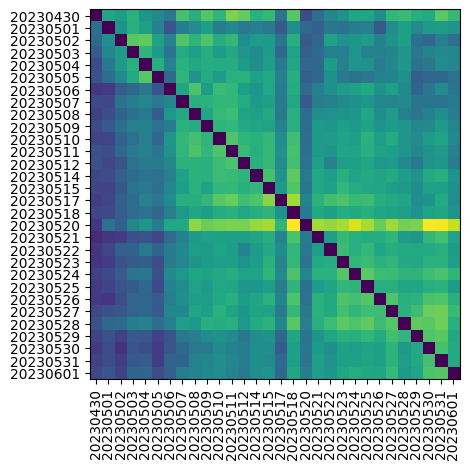

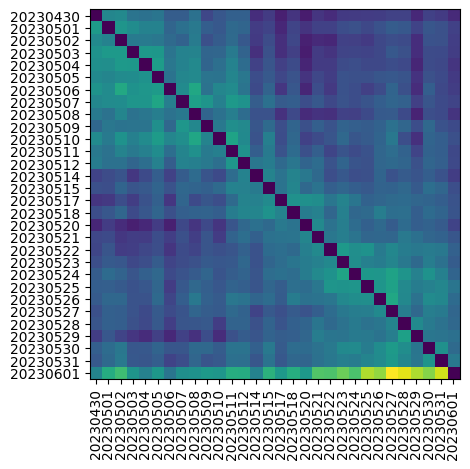

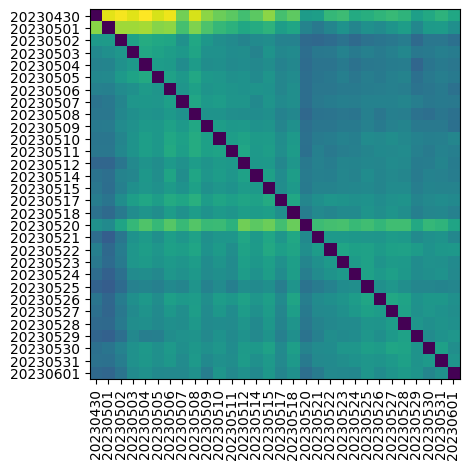

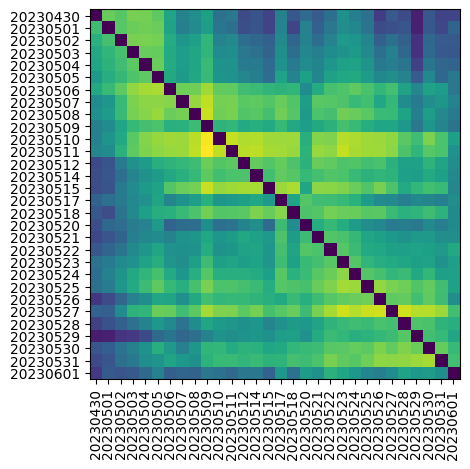

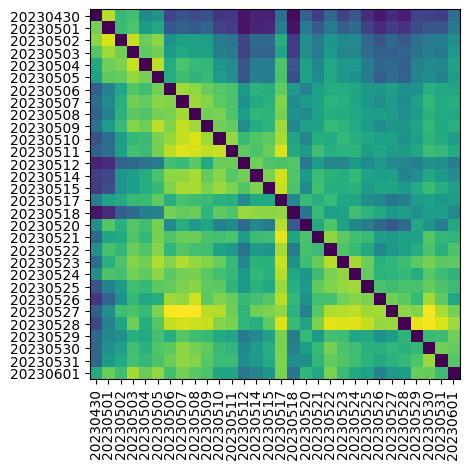

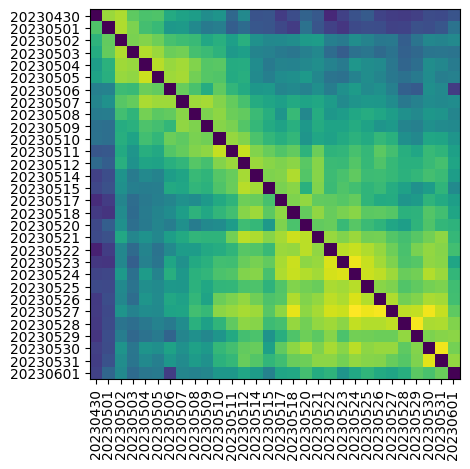

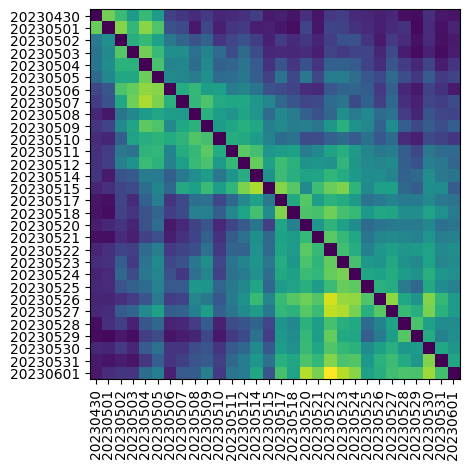

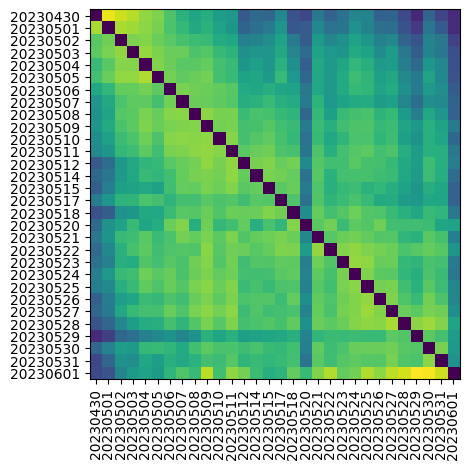

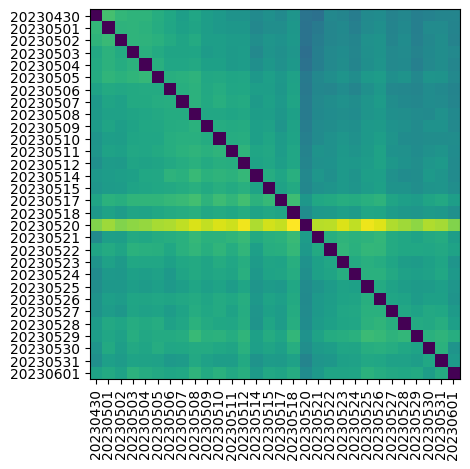

In [75]:
%matplotlib inline

for ii in range(EVRs_norm.shape[2]):
    fig = plt.figure()
    plt.imshow(EVRs_norm[:,:,ii])
    plt.xticks(np.arange(EVRs_norm.shape[0]), labels=models.keys(), rotation=90);
    plt.yticks(np.arange(EVRs_norm.shape[0]), labels=models.keys(), rotation=0);
    figsaver(fig, name_file=f'factors/factor_{ii}')

In [76]:
normalizer_2d = np.logical_not(np.eye(EVRs_norm.shape[0]))

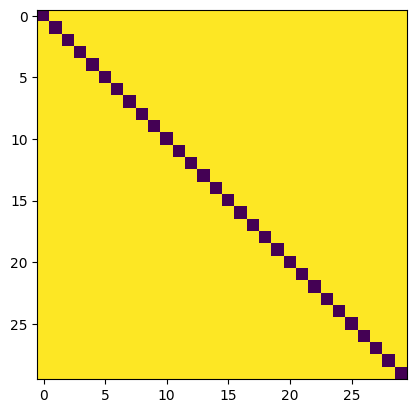

In [77]:
plt.figure()
plt.imshow(normalizer_2d)

In [78]:
import scipy.signal

In [79]:
gaus_2d = bnpm.featurization.gaussian_kernel_2D(
    image_size=(11,11),
    sig=1.5,
)
gaus_2d = gaus_2d / gaus_2d.sum()
    

In [80]:
EVRs_norm_conv = np.stack([scipy.signal.convolve2d(e, gaus_2d, mode='same', boundary='symm') for e in EVRs_norm.transpose(2,0,1)], axis=-1)

In [81]:
normalizer_conv = scipy.signal.convolve2d(normalizer_2d, gaus_2d, mode='same', boundary='symm')

In [82]:
normalizer_conv.shape

(30, 30)

In [83]:
EVRs_norm_conv_normd = EVRs_norm_conv / normalizer_conv[:,:,None]

RH Warning: Overwriting file. File: /media/rich/bigSSD/analysis_data/face_rhythm/mouse_0322N/drift/ims/EVRs_conv.png already exists.


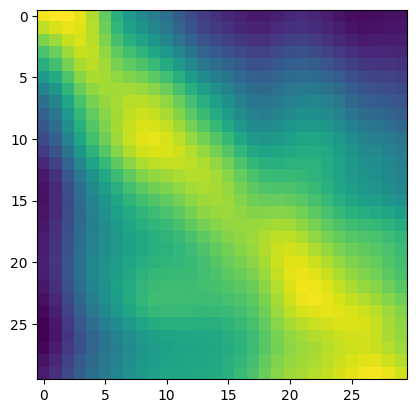

In [84]:
fig = plt.figure()
plt.imshow(EVRs_norm_conv_normd.mean(2), clim=[None,None])
figsaver(fig, name_file='EVRs_conv')

In [85]:
results = {
    'dir_dFoF': dir_dFoF,
    'dir_tca': dir_tca,
    'cv_test_size': cv.test_size,
    'automodel_params_RidgeRegression': automodel_partial.keywords['params_RidgeRegression'],
    'cv_n_splits': n_splits,
    'device': DEVICE_regression,
    'models': {key: [m.__dict__ for m in md] for key, md in models.items()},
    'evrs_date': evrs_date,
    'crossmodel_outs': crossmodel_outs,
    'rank': rank,
    'EVRs': EVRs,
    'EVRs_norm': EVRs_norm,
    'EVRs_norm_conv_normd': EVRs_norm_conv_normd,
}

In [86]:
bnpm.file_helpers.pickle_save(
    obj=results,
    filepath=f'/media/rich/bigSSD/analysis_data/face_rhythm/{mouse}/drift/decoding_drift.pkl',
    mode='wb',
    mkdir=True,
)